# Template for Spectral and temporal modifications Lab


*From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2019*

**python version : 3.6**

In [1]:
import os, sys, wave, struct

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython

from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write

## Functions

In [14]:
def load_sound(file):
    return wave.open(file, 'rb')
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

def nextpow2(x):
    assert x>0
    p = ceil(np.log2(x))
    x_ = 2**p
    assert 2**(p-1) < x <= x_
    return x_

def period(x, Fs, Pmin=1/300, Pmax=1/80, seuil=0.7) :
    # [P,voiced] = period(x,Fs,Pmin,Pmax,seuil);
    # If voiced = 1, P is the period signal x expressed in number of samples
    # If voiced = 0, P is equal to 10ms.Fs

    x = x - np.mean(x)
    N = len(x)

    Nmin = np.ceil(Pmin*Fs).astype(int)
    Nmax = 1 + np.floor(Pmax*Fs).astype(int)
    Nmax = np.min([Nmax,N])

    Nfft = nextpow2(2*N-1)
    X = np.fft.fft(x, n=Nfft)
    S = X * np.conj(X) / N
    r = np.real(np.fft.ifft(S))

    rmax = np.max(r[Nmin:Nmax])
    I = np.argmax(r[Nmin:Nmax])
    P = I+Nmin
    corr = (rmax/r[0]) * (N/(N-P))
    voiced = corr > seuil
    if not(voiced):
        P = np.round(10e-3*Fs)

    return P,voiced

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [3]:
data_path = os.getcwd()
filename = 'aeiou.wav'
sound = os.path.join(data_path, filename) 

### **Using wave**

In [4]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=11025, nframes=59964, comptype='NONE', compname='not compressed')


In [5]:
IPython.display.Audio('aeiou.wav')

In [6]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

In [7]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

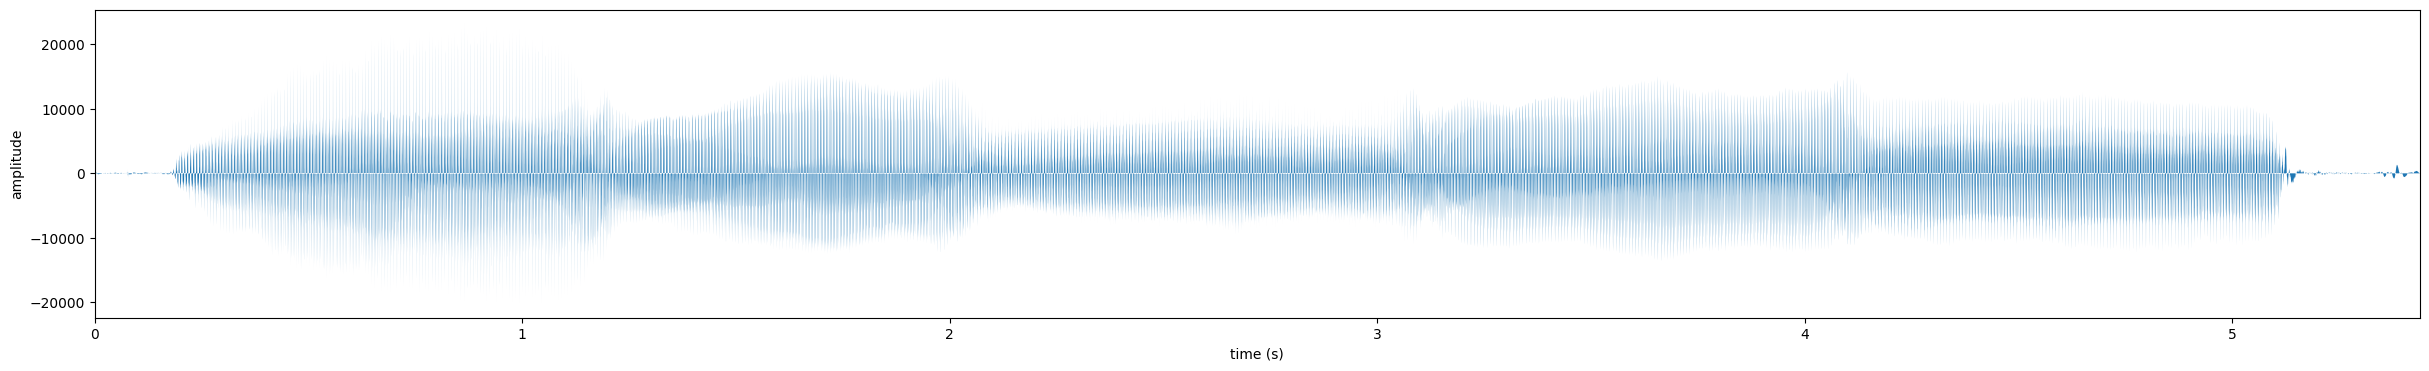

In [8]:
plot_sound(x, times)

In [9]:
write('new_aeiou.wav', Fs, np.array(x, dtype=np.int16)) # to write a new wave file

## I. Extraction of the analysis marks

In [11]:
def analysisPitchMarks(s, Fs) :
    P, voiced = period(x, Fs)
    n = len(voiced)
    A = np.zeros(3,n)
    for i in range(n) :
        A[1,i] = i
        A[2,i] = voiced[i]
        A[3,i] = P[i]
    return A

## II. Synthesis and modification of the temporal and spectral scales
### II.1) Signal synthesis

In [12]:
def synthesis(s, Fs, A, B) :
    N = len(s)
    num_frames = A.shape[0]
    frame_size = int((A[1, 0] - A[0, 0]) * Fs)
    y = np.zeros(N)
    for i in range(num_frames):
        start_index = int(A[i, 0] * Fs)
        end_index = start_index + frame_size
        frame = s[start_index:end_index]
        synthesis_mark = B[i, :]
        synthesis_mark = np.interp(np.arange(frame_size), synthesis_mark[:, 0] * Fs, synthesis_mark[:, 1])
        synthesized_frame = np.fft.irfft(synthesis_mark * np.fft.rfft(frame))
        y[start_index:end_index] += synthesized_frame

    return y

### II.2) Modification of temporal scale

In [13]:
def ChangeTimeScale(alpha, A, Fs):
    num_frames = A.shape[0]
    B = np.zeros((num_frames, A.shape[1], 2))
    B[0, :, 0] = A[0, :, 0]
    n = np.zeros((num_frames, A.shape[1]), dtype=int)
    f = np.zeros((num_frames, A.shape[1]))
    for k in range(1, num_frames):
        f[k, :] = (alpha * A[k, :, 0] - A[k-1, :, 0] * n[k-1, :]) % 1
        n[k, :] = ((alpha * A[k, :, 0] - A[k-1, :, 0] * n[k-1, :]) - f[k, :]) / 1
    for k in range(1, num_frames):
        for i in range(A.shape[1]):
            prev_index = int(A[k-1, i, 0] * Fs)
            curr_index = int(A[k, i, 0] * Fs)
            frame_length = curr_index - prev_index
            synthesis_locs = np.arange(frame_length) / alpha + prev_index + n[k, i]
            synthesis_amps = np.interp(synthesis_locs, A[k-1:k+1, i, 0] * Fs, A[k-1:k+1, i, 1])
            B[k, i, 0] = A[k, i, 0]
            B[k, i, 1] = synthesis_amps

    return B

### II.3) Modification of the spectral scale

In [15]:
def ChangePitchScale(beta, A, Fs, s):
    num_frames, num_channels = A.shape[:2]
    B = np.zeros((num_frames, num_channels, 2))
    B[0, :, 1] = A[0, :, 1]
    for k in range(1, num_frames):
        for i in range(num_channels):
            freqs = A[k-1:k+1, i, 1]
            synthesis_freqs = freqs * beta
            synthesis_locs = B[k-1, i, 0] + (synthesis_freqs / Fs)
            synthesis_amps = np.interp(synthesis_locs, np.arange(len(s)) / Fs, s)
            B[k, i, 0] = synthesis_locs[-1]
            B[k, i, 1] = synthesis_freqs[-1]

    return B